Displaying: frame_0000.jpg
Trying to load image from: ../Data/train_frames/train_A2_LT/frame_0000.jpg
Exists? True


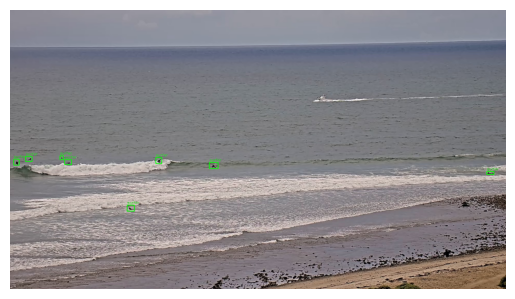

Displaying: frame_0100.jpg
Trying to load image from: ../Data/train_frames/train_A2_LT/frame_0100.jpg
Exists? True


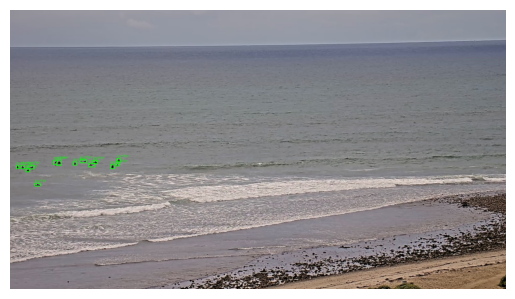

Displaying: frame_0300.jpg
Trying to load image from: ../Data/train_frames/train_A2_LT/frame_0300.jpg
Exists? True


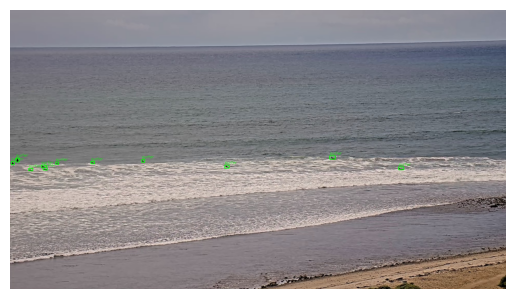

In [4]:
import cv2
import os
import matplotlib.pyplot as plt

# --- CONFIG ---
image_dir = '../Data/train_frames/train_A2_LT/'
label_dir = os.path.join(image_dir, 'annotations/obj_train_data')
image_ext = '.jpg'
label_ext = '.txt'
class_names = ['surfer']  # Make sure this matches obj.names

# --- FUNCTION TO DRAW BOXES ---
def draw_yolo_bboxes(image_path, label_path, class_names):
    image = cv2.imread(image_path)
    h, w, _ = image.shape

    with open(label_path, 'r') as f:
        for line in f.readlines():
            cls_id, x_center, y_center, bw, bh = map(float, line.strip().split())
            # Convert from YOLO to pixel coordinates
            x1 = int((x_center - bw / 2) * w)
            y1 = int((y_center - bh / 2) * h)
            x2 = int((x_center + bw / 2) * w)
            y2 = int((y_center + bh / 2) * h)
            
            # Draw rectangle
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            label = class_names[int(cls_id)]
            cv2.putText(image, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

    # Convert BGR (OpenCV) to RGB (Matplotlib)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

# --- VISUALIZE EXAMPLES ---
# Change this list to specific frames you want to check
sample_images = ['frame_0000.jpg', 'frame_0100.jpg', 'frame_0300.jpg']

for img_file in sample_images:
    label_file = img_file.replace(image_ext, label_ext)
    img_path = os.path.join(image_dir, img_file)
    label_path = os.path.join(label_dir, label_file)
    
    print(f"Displaying: {img_file}")
    print(f"Trying to load image from: {img_path}")
    print(f"Exists? {os.path.exists(img_path)}")

    draw_yolo_bboxes(img_path, label_path, class_names)
